<a href="https://colab.research.google.com/github/Bibhash123/Zindi-Armyworm/blob/main/notebooks/Zindi_Armyworm_Segmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import random
from PIL import Image
import cv2
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
import tensorflow_hub as hub

In [ ]:
def seedAll(seed):
  np.random.seed(seed)
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  tf.random.set_seed(seed)

seedAll(101)

In [ ]:
url = "https://api.zindi.africa/v1/competitions/makerere-fall-armyworm-crop-challenge/files/"
token = {'auth_token': '56eo46oXnWGoHHmrLLDq5xRJ'} 

In [ ]:
def zindi_data_downloader(url, token, file_name):
    # Get the competition data
    competition_data = requests.post(url = f"{url}{file_name}", data= token, stream=True)
    
    # Progress bar monitor download
    pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
    # Create and Write the data to colab drive in chunks
    handle = open(file_name, "wb")
    for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
        if chunk: # filter out keep-alive new chunks
                handle.write(chunk)
        pbar.update(len(chunk))
    handle.close()
    pbar.close()

In [ ]:
zindi_data_downloader(url,token,"Train.csv")
zindi_data_downloader(url,token,"Test.csv")
zindi_data_downloader(url,token,"SampleSubmission.csv")
zindi_data_downloader(url,token,"Images.zip")
!unzip -q "Images.zip" -d "/content/data"

Train.csv:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

Test.csv:   0%|          | 0.00/44.3k [00:00<?, ?B/s]

SampleSubmission.csv:   0%|          | 0.00/48.5k [00:00<?, ?B/s]

Images.zip:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

In [ ]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [ ]:
train.shape,test.shape

((1619, 2), (1080, 1))

In [ ]:
train['Label'].value_counts()

0    810
1    809
Name: Label, dtype: int64

In [ ]:
train.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


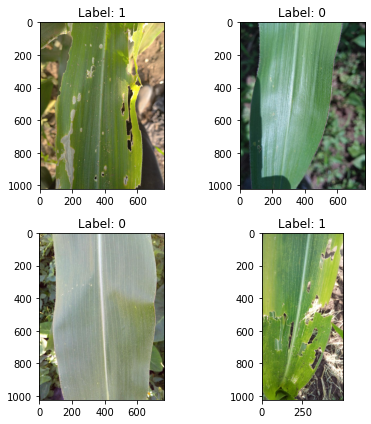

In [ ]:
fig,ax = plt.subplots(2,2,figsize = (6,6))
ax = ax.flatten()
for idx, row in train.iloc[:4].iterrows():
  ax[idx].imshow(np.asarray(Image.open(f"/content/data/{row['Image_id']}")))
  ax[idx].set_title(f"Label: {row['Label']}")
plt.tight_layout()
plt.show()

In [ ]:
def segment(image_name):
  image = np.asarray(Image.open(f"/content/data/{image_name}"))
  img = np.float32(image).reshape((-1,3))
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
  
  # then perform k-means clustering wit h number of clusters defined as 3
  #also random centres are initially choosed for k-means clustering
  k = 2
  retval, labels, centers = cv2.kmeans(img, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  
  # convert data into 8-bit values
  # centers = np.uint8(centers)
  centers = np.array([[0,0,0],[255,255,255]])
  segmented_data = centers[labels.flatten()]
  
  # reshape data into the original image dimensions
  segmented_image = segmented_data.reshape((image.shape))
  return segmented_image

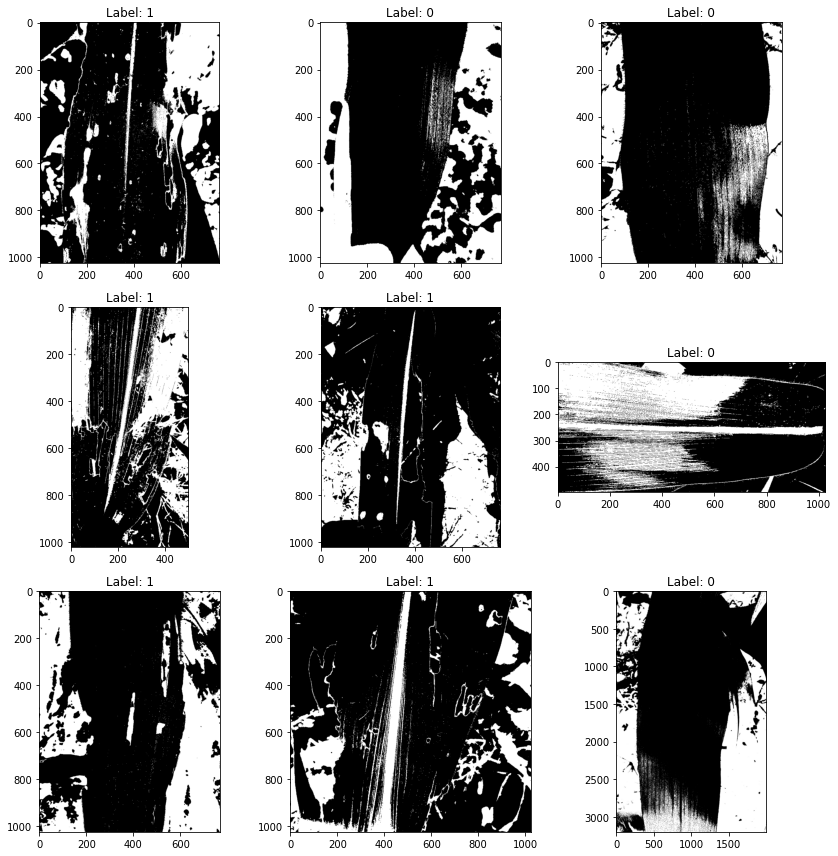

In [ ]:
fig,ax = plt.subplots(3,3,figsize = (12,12))
ax = ax.flatten()
for idx, row in train.iloc[:9].iterrows():
  ax[idx].imshow(segment(row['Image_id']))
  ax[idx].set_title(f"Label: {row['Label']}")
plt.tight_layout()
plt.show()

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

In [ ]:
if not os.path.isdir("/content/segmented/"):
  os.mkdir("/content/segmented/")
  os.mkdir("/content/segmented/images/")
for f in tqdm(os.listdir("/content/data/"), "Segmenting Images:"):
  seg_img = segment(f)
  cv2.imwrite(os.path.join("/content/segmented/images/",f),seg_img)

Segmenting Images::   0%|          | 0/2699 [00:00<?, ?it/s]

In [ ]:
!kaggle datasets init -p "/content/segmented/"

Data package template written to: /content/segmented/dataset-metadata.json


In [ ]:
!kaggle datasets create -p "/content/segmented/" --dir-mode zip

Starting upload for file images.zip
100% 703M/703M [00:10<00:00, 67.5MB/s]
Upload successful: images.zip (703MB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/bericdondarion/zindisegment


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
N_SPLIT = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
from functools import partial
def decode_fn(is_labelled):
  def without_labels(path, segpath, target_size=IMG_SIZE, test = False):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(file_bytes, channels = 0)
    if img.shape[0]!=target_size:
      img = tf.image.resize(img, (target_size,target_size))
    
    file_bytes = tf.io.read_file(path)
    segimg = tf.image.decode_jpeg(file_bytes, channels = 0)
    if segimg.shape[0]!=target_size:
      segimg = tf.image.resize(segimg, (target_size,target_size))
    # img = centerCrop(img,100)
    if not test:
      return img,segimg
    else:
      return (img,segimg),tf.ones((1,1))
  
  def with_label(path, segimg, label, target_size=IMG_SIZE):
    return without_labels(path, segimg, target_size), label

  return with_label if is_labelled else without_labels

def createTFDataset(dataframe,
                    batch_size,
                    batch = True,
                    is_labelled = True,
                    shuffle = True,
                    cache = True,
                    repeat = True,
                    file_path = "/content/data/",
                    seg_path = "/content/segmented/images/",
                    test=False):
  df = dataframe.copy()
  df['paths'] = df['Image_id'].apply(lambda x: os.path.join(file_path,x))
  df['segpaths'] = df['Image_id'].apply(lambda x: os.path.join(seg_path,x))

  decoder = decode_fn(is_labelled)
  if is_labelled:
    dataset = tf.data.Dataset.from_tensor_slices((df['paths'].values,
                                                  df['segpaths'].values,
                                                  df['Label'].values
                                                  ))
  else:
    dataset = tf.data.Dataset.from_tensor_slices((df['paths'].values,
                                                  df['segpaths'].values))
  dataset = dataset.map(partial(decoder,test = test), num_parallel_calls = AUTOTUNE)
  dataset = dataset.cache("") if cache else dataset
  dataset = dataset.repeat() if repeat else dataset
  dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset
  dataset = dataset.batch(batch_size,drop_remainder=False) if batch else dataset
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset

In [ ]:
train['fold'] = -1
skf = StratifiedKFold(n_splits = N_SPLIT,shuffle = True,random_state = 101)
for idx,(trn_,val_) in enumerate(skf.split(train['Image_id'],train['Label'])):
  train.loc[val_,'fold'] = idx

In [ ]:
def buildModel():
  m1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False, weights = 'imagenet', input_shape= (IMG_SIZE,IMG_SIZE,3))
  total = len(m1.layers)
  for idx,layer in enumerate(m1.layers):
    if idx>total-30:
      layer.trainable = True
    else:
      layer.trainable = False

  m2 = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False, weights = 'imagenet', input_shape= (IMG_SIZE,IMG_SIZE,3))
  total = len(m2.layers)
  for idx,layer in enumerate(m2.layers):
    if idx>total-30:
      layer.trainable = True
    else:
      layer.trainable = False

  augmenter = tf.keras.Sequential([
                                   L.RandomFlip(mode="horizontal_and_vertical"),
                                   L.RandomRotation(0.1),
                                   L.RandomContrast(0.1)
  ])

  head1 = tf.keras.Sequential([
                      m1,
                      L.Flatten()
                    ])
  
  head2 = tf.keras.Sequential([
                      m2,
                      L.Flatten()
                    ])
  
  inp = L.Input(shape = (IMG_SIZE,IMG_SIZE,3))
  inp2 = L.Input(shape = (IMG_SIZE,IMG_SIZE,3))
  # aug = augmenter(inp)
  h1 = head1(inp)
  h2 = head2(inp2)
  h = L.Concatenate(axis=-1)([h1,h2])
  h = L.Dropout(0.1)(h)
  h = L.Dense(128,activation='relu')(h)
  h = L.BatchNormalization()(h)
  h = L.Dropout(0.1)(h)
  h = L.Dense(64,activation='relu')(h)
  h = L.BatchNormalization()(h)
  h = L.Dropout(0.1)(h)
  h = L.Dense(32,activation='relu')(h)
  h = L.BatchNormalization()(h)
  h = L.Dropout(0.1)(h)
  h = L.Dense(16,activation='relu')(h)
  h = L.Dropout(0.1)(h)
  h = L.Dense(1,activation='sigmoid')(h)

  model = tf.keras.Model(inputs = [inp,inp2],outputs = h)
  schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-3,
                                                            decay_steps=140,
                                                            decay_rate=0.96,
                                                            staircase=True)  
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ["accuracy"])
  return model

In [ ]:
for fold in range(N_SPLIT):
  print(f"============================= Fold {fold} =========================================")
  trn = createTFDataset(train[train['fold']!=fold],
                        batch_size=BATCH_SIZE,
                        batch = True,
                        is_labelled = True,
                        shuffle = True,
                        cache = False,
                        repeat = True,
                        file_path = "/content/data/")
  val = createTFDataset(train[train['fold']==fold],
                        batch_size=BATCH_SIZE,
                        batch = True,
                        is_labelled = True,
                        shuffle = False,
                        cache = False,
                        repeat = False,
                        file_path = "/content/data/")
  K.clear_session()
  model = buildModel()
  ckpt = tf.keras.callbacks.ModelCheckpoint(f"model_{fold}.hdf5",monitor = 'val_loss',mode = 'min',
                                            save_best_only = True, save_weights_only = True)
  es = tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss', mode = 'min')

  history = model.fit(trn,
                      epochs = 30,
                      steps_per_epoch = train[train['fold']!=fold].shape[0]//BATCH_SIZE,
                      validation_data = val,
                      callbacks = [ckpt,es])
  
  best_idx = np.argmin(history.history['val_loss'])
  print("\nBest Val Loss:",history.history['val_loss'][best_idx])
  print("Best Val Accuracy:",history.history['val_accuracy'][best_idx])

============================= Fold 0 =========================================
Epoch 1/30
80/80 [==============================] - 30s 168ms/step - loss: 0.2632 - accuracy: 0.9047 - val_loss: 0.1656 - val_accuracy: 0.9475
Epoch 2/30
80/80 [==============================] - 11s 138ms/step - loss: 0.1288 - accuracy: 0.9617 - val_loss: 0.0480 - val_accuracy: 0.9846
Epoch 3/30
80/80 [==============================] - 11s 140ms/step - loss: 0.0683 - accuracy: 0.9812 - val_loss: 0.0258 - val_accuracy: 0.9907
Epoch 4/30
80/80 [==============================] - 15s 190ms/step - loss: 0.0561 - accuracy: 0.9797 - val_loss: 0.0547 - val_accuracy: 0.9753
Epoch 5/30
80/80 [==============================] - 11s 144ms/step - loss: 0.0555 - accuracy: 0.9844 - val_loss: 0.1353 - val_accuracy: 0.9599
Epoch 6/30
80/80 [==============================] - 10s 127ms/step - loss: 0.0619 - accuracy: 0.9766 - val_loss: 0.0281 - val_accuracy: 0.9938
Epoch 7/30
80/80 [==============================] - 9s 118ms/st

In [ ]:
def getY(x,y):
  return y
scores = []
for fold in tqdm(range(5)):
  val = createTFDataset(train[train['fold']==fold],
                        batch_size=BATCH_SIZE,
                        batch = True,
                        is_labelled = True,
                        shuffle = False,
                        cache = False,
                        repeat = False,
                        file_path = "/content/data/")
  model = buildModel()
  model.load_weights(f'model_{fold}.hdf5')
  pred = model.predict(val)
  truth = np.asarray(list(val.map(getY).unbatch().as_numpy_iterator()))
  sc = roc_auc_score(truth,pred)
  scores.append(sc)
  print(f"Fold {fold+1}:",sc)
print("\nCV Score:",np.mean(scores))

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1: 0.9997713763145861
Fold 2: 0.9994665447340344
Fold 3: 0.9995427526291725
Fold 4: 0.9993522328913276
Fold 5: 1.0

CV Score: 0.9996265813138241


In [ ]:
tst = createTFDataset(test,
                      batch_size = BATCH_SIZE,
                      batch = True,
                      is_labelled = False,
                      shuffle = False,
                      cache = False,
                      repeat = False,
                      file_path = "/content/data/",
                      test = True)

pred = np.zeros((test.shape[0],1))
for fold in tqdm(range(5)):
  model = buildModel()
  model.load_weights(f'model_{fold}.hdf5')
  pred += model.predict(tst)/5

ss = pd.read_csv("SampleSubmission.csv")
ss.iloc[:,1] = pred

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
ss.to_csv("armyworm_seg.csv",index=False)
ss

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0.096201
1,id_03dqinf6w0znv.jpg,0.004384
2,id_046yl0cxn3ybz.jpg,0.999231
3,id_04athdtx2abyg.jpg,0.002873
4,id_062aauf9e9jk0.jpg,0.005520
...,...,...
1075,id_zv5fvjnakvf1r.jpg,0.995195
1076,id_zvpikh1z30arn.jpg,0.001143
1077,id_zypilwkudljyz.jpg,0.001489
1078,id_zz9lwehh5sxdp.jpg,0.980108


In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive/")

In [ ]:
# !mkdir "/content/gdrive/MyDrive/saved_models/"
# !mkdir "/content/gdrive/MyDrive/saved_models/zindi-armyworm/"
# !cp "model_0.hdf5" "/content/gdrive/MyDrive/saved_models/zindi-armyworm/"
# !cp "model_1.hdf5" "/content/gdrive/MyDrive/saved_models/zindi-armyworm/"
# !cp "model_2.hdf5" "/content/gdrive/MyDrive/saved_models/zindi-armyworm/"
# !cp "model_3.hdf5" "/content/gdrive/MyDrive/saved_models/zindi-armyworm/"
# !cp "model_4.hdf5" "/content/gdrive/MyDrive/saved_models/zindi-armyworm/"

In [ ]:
# drive.flush_and_unmount()